In [1]:
!pip uninstall tensorflow tensorflow_gpu protobuf --yes

Uninstalling tensorflow-1.4.0:
  Successfully uninstalled tensorflow-1.4.0
Cannot uninstall requirement tensorflow-gpu, not installed
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install tensorflow_gpu

    100% |████████████████████████████████| 229.6MB 5.8kB/s eta 0:00:01   10% |███▎                            | 23.7MB 54.5MB/s eta 0:00:04    11% |███▋                            | 26.3MB 52.8MB/s eta 0:00:04    12% |████                            | 28.9MB 51.2MB/s eta 0:00:04    58% |██████████████████▉             | 134.9MB 65.7MB/s eta 0:00:02
    100% |████████████████████████████████| 92kB 9.3MB/s eta 0:00:01
    100% |████████████████████████████████| 3.3MB 377kB/s eta 0:00:01
    100% |████████████████████████████████| 9.3MB 143kB/s eta 0:00:01
  Running setup.py bdist_wheel for absl-py ... done
  Stored in directory: /root/.cache/pip/wheels/4c/16/ef/e36a23f2432e9220f8845f94e2c3abd39e7d9d1cd458d3159d
  Running setup.py bdist_wheel for gast ... done
  Stored in directory: /root/.cache/pip/wheels/9a/1f/0e/3cde98113222b853e98fc0a8e9924480a3e25f1b4008cedb4f
  Running setup.py bdist_wheel for termcolor ... done
  Stored in directory: /root/.cache/pip/wheels/7c/06/54/bc84598ba1daf8

In [3]:
import scipy
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal as norm
%matplotlib inline 

tfd = tf.contrib.distributions
tfn = tf.contrib.rnn
tfl = tf.linalg
dynrnn = tf.nn.dynamic_rnn

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [4]:
print(tf.__version__)

1.9.0


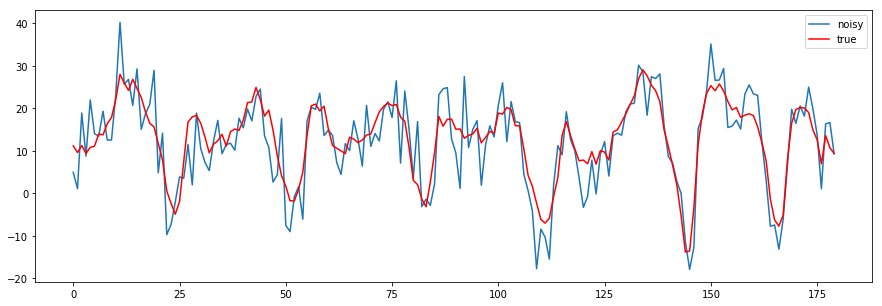

In [5]:
np.random.seed(1)
n_hidden = 140; seq_length = 300; training_size = 300
h = np.zeros((training_size, seq_length + 1, n_hidden)); 
# h[:, 0, :] = norm.rvs(mean=None, cov=np.eye(20), size=100)
h[:, 0, :] = np.zeros((training_size, n_hidden))
y = np.zeros((training_size, seq_length + 1, 1)); y[:, 0] = np.zeros((training_size, 1))
sigma_c = 5.3
sigma_b = 1.

A = 0.8 * np.random.randn(n_hidden, n_hidden)
R = scipy.linalg.expm(A - A.T)
B = 0.2 * np.random.randn(1, n_hidden)
b = 1 * np.random.randn(n_hidden, 1)
c = 1 * np.random.randn(n_hidden, 1)
bias_h = np.random.rand(1, n_hidden)

for i in range(1, seq_length + 1):
    h[:, i, :] = np.tanh(np.dot(h[:, i-1, :], R) + np.dot(y[:, i-1], B)) + 0.7 * h[:, i-1, :] + bias_h
    y[:, i] = 1 * np.dot(h[:, i, :], b) + np.tanh(np.dot(h[:, i, :], c)) - 1 + sigma_b * np.random.randn(training_size, 1)

y = y[:, 1:]
fig, ax = plt.subplots(1,1,figsize=(15, 5))
y_tilde = (y + sigma_c * np.random.randn(training_size, seq_length, 1))
plt.plot(y_tilde[0, 20:200], label='noisy');
plt.plot(y[0, 20:200], 'r', label='true');
plt.legend();

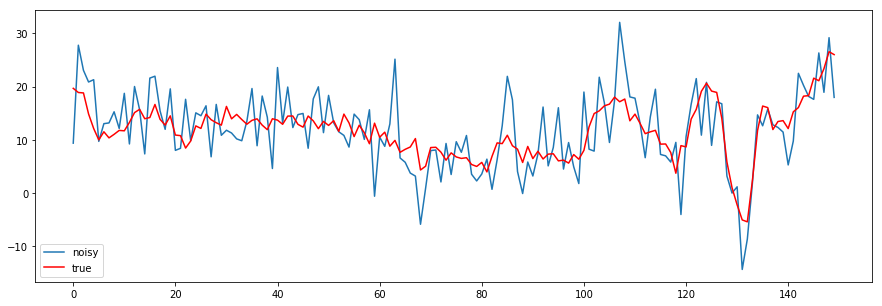

In [6]:
idx = np.random.randint(0, 100)
fig, ax = plt.subplots(1,1,figsize=(15, 5))
plt.plot(y_tilde[idx, 50:200], label='noisy');
plt.plot(y[idx, 50:200], 'r', label='true');
plt.legend();

In [7]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

In [8]:
class GaussianCell(tf.contrib.rnn.RNNCell):
    
    def __init__(self, cell, event_size, std, reuse=None):       
        super(GaussianCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size
        self._std = std[None, None]

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return (self._event_size, self._event_size)

    def call(self, inputs, state):
        hidden, state = self._cell(inputs, state)
        mean = tf.layers.dense(hidden, self._event_size)
        n_samples = mean.shape[0]
        return (mean, tf.tile(self._std, (n_samples, self._event_size))), state
    
class SamplingCellWithInputs(tf.contrib.rnn.RNNCell):
    
    def __init__(self, cell, output_size, reuse=None):
        super(SamplingCellWithInputs, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size)
    
    def call(self, inputs , state_and_sample):
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(tf.concat([sample, inputs], 1), state)
        sample = tfd.Normal(mean, std).sample()
        return (mean, sample), (state, sample)
    
class SamplingCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a sequence in autoregressive mode by sampling at
    each step
    """

    def __init__(self, cell, output_size, reuse=None):
        super(SamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size)

    def call(self, _ , state_and_sample):
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(sample, state)
        sample = tfd.Normal(mean, std).sample()
        return (mean, sample), (state, sample)

In [9]:
class RobustARGenerator(object):
    """
    Model to test
    """
    def __init__(self, data, n_hidden, n_samples, seq_length, batch_size):
        self._data = data                                         # B x T x D
        self._B = batch_size                                      # B
        self._T = seq_length                                      # T
        self._D = 1                                               # D
        self._H = n_hidden                                        # H
        self._Sz = n_samples                                      # Sz
        self._Z = 20                                              # Z
        
        self.initialise_variables
        self.q_z = self.make_posterior_z
        self.p_y = self.make_transitional
        self.compute_elbo
        self.optimise
        
        self.make_forward_posterior
        self.make_forward_parameters
        self.compute_forward_message
        self.compute_elbo_forward
        self.forward_E_step
        self.forward_M_step
    
    @define_scope
    def initialise_variables(self):
        self._gen_std = tf.nn.softplus(tf.get_variable('generative_std', shape=(),
                                         initializer=tf.constant_initializer(2))) + 1e-5
        
        self._trans_std = tf.nn.softplus(tf.get_variable('transitional_std', shape=(),
                                         initializer=tf.constant_initializer(5))) + 1e-5
        
        self._cell = tfn.GRUBlockCell(self._H)
        self._gauss_cell = GaussianCell(self._cell, self._D, self._trans_std)
        self._sampling_cell = SamplingCell(self._gauss_cell, self._D)
        self._layer = tf.layers.Dense(self._H, tf.nn.relu)
        self._post_cell_z = tfn.GRUBlockCell(self._H)
        self._optimiser = tf.train.AdamOptimizer(0.001)
    
    @define_scope
    def make_posterior_z(self):
        _, h = dynrnn(self._post_cell_z, self._data, dtype=tf.float32)
        means = tf.layers.dense(h, self._Z)
        stds = tf.layers.dense(h, self._Z, tf.nn.softplus) + 1e-5
        posterior_z = tfd.MultivariateNormalDiag(means, stds)
        return posterior_z
    
    @define_scope
    def make_kl_z(self):
        p = tfd.MultivariateNormalDiag(np.zeros(self._Z, dtype=np.float32), np.ones(self._Z, dtype=np.float32))
        return tf.reduce_sum(tfd.kl_divergence(self.q_z, p))
    
    @define_scope
    def make_transitional(self):
        self._code_z = self.q_z.sample((self._Sz))
        hidden = self._layer(tf.reshape(self._code_z, [-1, self._Z]))                         # (Sz * B) x H
        state_and_sample = (hidden, tf.zeros((self._B * self._Sz, self._D)))
        inputs = tf.zeros((self._B * self._Sz, self._T, self._D))
        (means, self._code_y), _ = dynrnn(self._sampling_cell, initial_state=state_and_sample, inputs=inputs)
        means = tf.identity(means, name='means')
        return tfd.MultivariateNormalDiag(means, scale_identity_multiplier=self._trans_std)
    
    @define_scope
    def make_reconstruction(self):
        gen_prob = tfd.MultivariateNormalDiag(self._code_y, scale_identity_multiplier=self._gen_std)
        data = tf.reshape(tf.tile(self._data[None, ...], (self._Sz, 1, 1, 1)), [-1, self._T, self._D])
        return tf.reduce_sum(gen_prob.log_prob(data))/self._Sz
    
    @define_scope
    def compute_elbo(self):
        kl_z = self.make_kl_z        
        reconstruction = self.make_reconstruction
        loss = reconstruction - kl_z
        
        return loss, kl_z, reconstruction

    @define_scope
    def optimise(self):
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo[0]))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))
    
    @define_scope
    def make_forward_posterior(self):
        y_mu = tf.get_variable(shape=(self._D), name='forward_y_mean', initializer=tf.constant_initializer(0))
        y_sigma = tf.nn.softplus(tf.get_variable(shape=(), initializer=tf.constant_initializer(2), 
                                                 name='forward_y_std'))
        return tfd.MultivariateNormalDiag(y_mu, scale_identity_multiplier=y_sigma)

    @define_scope
    def make_forward_parameters(self):
        return tf.get_variable(shape=(30, self._D), name='best_forward_sequence', 
                               initializer=tf.constant_initializer(0))
    
    @define_scope
    def compute_forward_message(self):
        h = self._layer(self._code_z[:, 0])                                                # Sz x H
        code = self._code_y                                                                # (Sz * B) x T x D
        code = tf.reshape(code, [self._Sz, self._B, self._T, self._D])[:, 0]               # Sz x T x D
        code = tf.concat([tf.zeros((self._Sz, 1, self._D)), code[:, 1:]], 1)               # Sz x T x D
        _, hT = dynrnn(self._cell, inputs=code, initial_state=h)
#         for t in range(self._T):
#             _, h = self._cell(code[:, t], h)
        hT = tf.tile(tf.reduce_mean(hT, 0, keep_dims=True), [self._Sz, 1])
        
        trans_means = tf.reshape(self.make_transitional.mean(), [self._Sz, self._B, self._T, self._D])[:, 0]
        dist_y = tfd.MultivariateNormalDiag(trans_means[:, 0, -1:], scale_identity_multiplier=self._trans_std)
        return dist_y, hT
    
    @define_scope
    def make_rnn_forward(self):
        _, hT = self.compute_forward_message
        fake_inputs = tf.zeros((self._Sz, 30, self._D))
        code = self.make_forward_posterior.sample((self._Sz))
        (means, _), _ = dynrnn(self._sampling_cell, inputs=fake_inputs, initial_state=(hT, code))
        return tfd.MultivariateNormalDiag(means, scale_identity_multiplier=self._trans_std)
    
    @define_scope
    def make_forward_kl_y(self):
        return tf.reduce_mean(tfd.kl_divergence(self.make_forward_posterior, self.compute_forward_message[0]))
    
    @define_scope
    def make_forward_reconstruction(self):
        pred = self.make_forward_parameters
        return tf.reduce_sum(self.make_rnn_forward.log_prob(pred[None, ...]))/self._Sz
    
    @define_scope
    def compute_elbo_forward(self):
        kl = self.make_forward_kl_y
        reconstruction = self.make_forward_reconstruction        
        return reconstruction - kl
    
    @define_scope
    def forward_E_step(self):
        var_e = [v for v in tf.trainable_variables() if 'make_forward_posterior' in v.name]
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo_forward, var_list=var_e))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))
    
    @define_scope
    def forward_M_step(self):
        var_m = [v for v in tf.trainable_variables() if 'make_forward_parameters' in v.name]
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo_forward, var_list=var_m))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))

In [ ]:
tf.reset_default_graph()

seq_length = 50; n_samples = 500; batch_size = 20;
data = y_tilde[:, 50:50+seq_length]
x_ = tf.placeholder(tf.float32, [batch_size, seq_length, 1])

gen_model = RobustARGenerator(x_, n_hidden=30, n_samples=n_samples, seq_length=seq_length, batch_size=batch_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
# tf.train.Saver().restore(sess, "./model_for_prediction.ckpt")

elbos = []; kls_z = []; llks = []; stds = []; gen_stddevs = [];

for i in range(30001):
    idx = np.random.randint(0, training_size, batch_size)
    batch = data[idx, ...]
    
    elbo, kl_z, llk = sess.run(gen_model.compute_elbo, {x_: batch})
    elbos.append(elbo); kls_z.append(kl_z); llks.append(llk)
    
    stds.append(sess.run(gen_model._trans_std, {x_: batch}))
    gen_stddevs.append(sess.run(gen_model._gen_std, {x_: batch}))
        
    if i % 5000 == 0:
        print('Iteration:', i, 'ELBO:', elbo, 'KL (z):', kl_z, 'Reconstruction:', llk)
        
    sess.run(gen_model.optimise, {x_: batch})

Iteration: 0 ELBO: -38851.1 KL (z): 315.02 Reconstruction: -38536.1


In [31]:
tf.trainable_variables()

[<tf.Variable 'initialise_variables/generative_std:0' shape=() dtype=float32_ref>,
 <tf.Variable 'initialise_variables/transitional_std:0' shape=() dtype=float32_ref>,
 <tf.Variable 'make_posterior_z/rnn/gru_cell/w_ru:0' shape=(31, 60) dtype=float32_ref>,
 <tf.Variable 'make_posterior_z/rnn/gru_cell/b_ru:0' shape=(60,) dtype=float32_ref>,
 <tf.Variable 'make_posterior_z/rnn/gru_cell/w_c:0' shape=(31, 30) dtype=float32_ref>,
 <tf.Variable 'make_posterior_z/rnn/gru_cell/b_c:0' shape=(30,) dtype=float32_ref>,
 <tf.Variable 'make_posterior_z/dense/kernel:0' shape=(30, 20) dtype=float32_ref>,
 <tf.Variable 'make_posterior_z/dense/bias:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'make_posterior_z/dense_1/kernel:0' shape=(30, 20) dtype=float32_ref>,
 <tf.Variable 'make_posterior_z/dense_1/bias:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'make_transitional/dense/kernel:0' shape=(20, 30) dtype=float32_ref>,
 <tf.Variable 'make_transitional/dense/bias:0' shape=(30,) dtype=float32_ref>,

In [33]:
tf.train.Saver().save(sess, './model_for_prediction.ckpt')

'./model_for_prediction.ckpt'

In [ ]:
elbos_forward = [];

for i in range(15001):   
    elbo_forward = sess.run(gen_model.compute_elbo_forward, {x_: batch})
    sess.run(gen_model.forward_E_step, {x_: batch})
    sess.run(gen_model.forward_M_step, {x_: batch})
    
    elbos_forward.append(elbo_forward)
    
    if i % 1000 == 0:
        print('Iteration:', i, 'ELBO Forward:', elbo_forward)

Iteration: 0 ELBO Forward: -53227.2
Iteration: 1000 ELBO Forward: -45486.2
Iteration: 2000 ELBO Forward: -48868.3
Iteration: 3000 ELBO Forward: -50343.8
Iteration: 4000 ELBO Forward: -61188.2
Iteration: 5000 ELBO Forward: -61687.2
Iteration: 6000 ELBO Forward: -43531.2
Iteration: 7000 ELBO Forward: -49572.3
Iteration: 8000 ELBO Forward: -61815.8
Iteration: 9000 ELBO Forward: -51691.7
Iteration: 10000 ELBO Forward: -47898.0


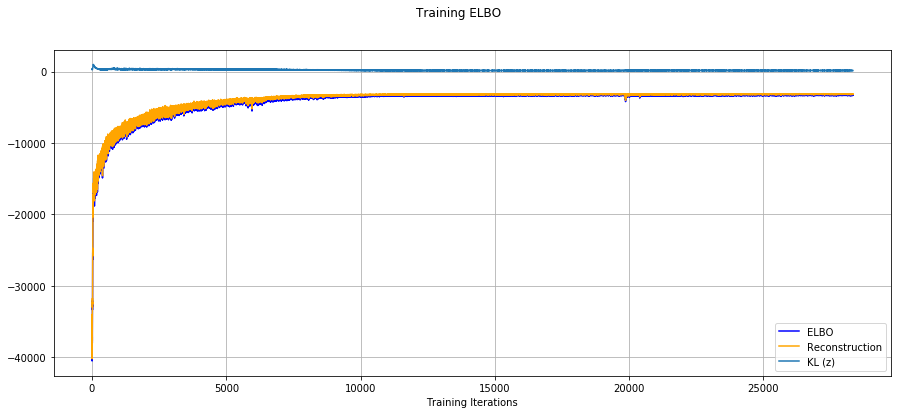

In [20]:
# New plot
fig, ax = plt.subplots(1, 1, figsize=(15,6))
plt.plot(elbos, 'b', label='ELBO')
plt.plot(llks, 'orange', label='Reconstruction')
plt.plot(kls_z, label='KL (z)')
plt.suptitle('Training ELBO')
ax.set_xlabel('Training Iterations')
plt.grid("on")
plt.legend();

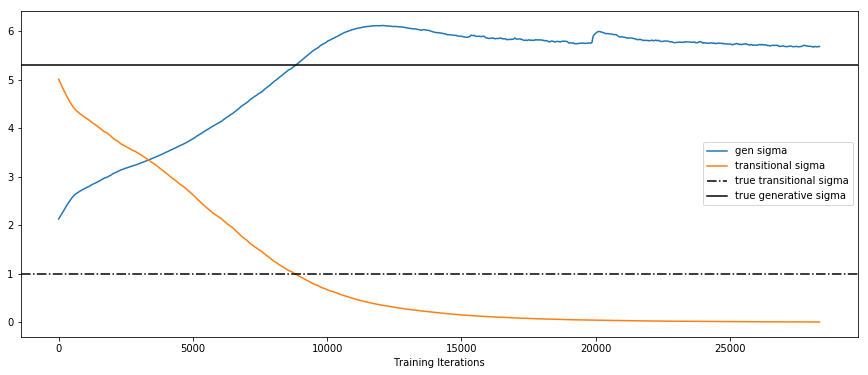

In [21]:
# 
trans_means_op = tf.get_default_graph().get_tensor_by_name('make_transitional/means:0')
means = sess.run(trans_means_op, {x_: batch})
latents = sess.run(gen_model._code_y, {x_: batch})
#     
fig, ax = plt.subplots(1, 1, figsize=(15,6))
plt.plot(gen_stddevs, label='gen sigma')
plt.plot([np.mean(s) for s in stds], label='transitional sigma')
plt.axhline(sigma_b, color='k', linestyle='-.', label='true transitional sigma')
plt.axhline(sigma_c, color='k', label='true generative sigma')
ax.set_xlabel('Training Iterations')
plt.legend();

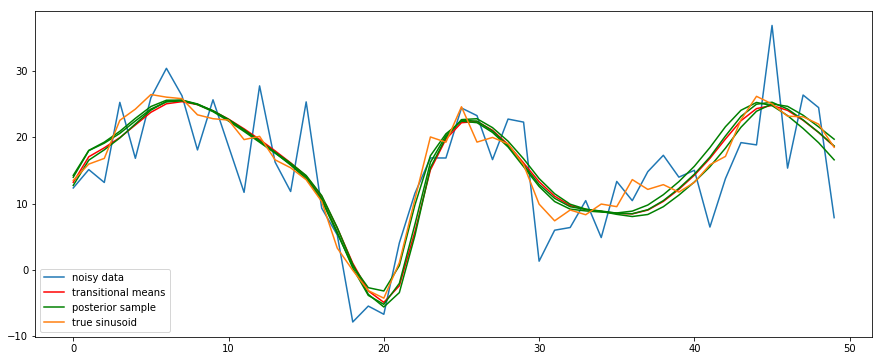

In [32]:
i = np.random.randint(0, batch_size)
plt.subplots(1,1,figsize=(15,6))
plt.plot(batch[i, :], label='noisy data')
plt.plot(np.mean(np.reshape(means, (n_samples, batch_size, seq_length, 1)), 0)[i], 'r-', label='transitional means')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[1, i] , 'g', label='posterior sample')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[0, i] , 'g')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[2, i] , 'g')
plt.plot(y[idx[i], 50:50+seq_length], label='true sinusoid')
plt.legend();

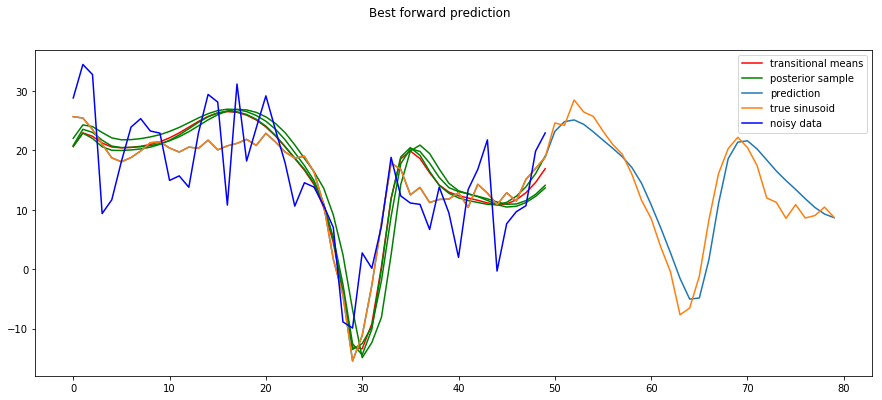

In [40]:
# Best forward pred at 10000 iters
trans_means_op = tf.get_default_graph().get_tensor_by_name('make_transitional/means:0')
means = sess.run(trans_means_op, {x_: batch})
latents = sess.run(gen_model._code_y, {x_: batch})
continuation = sess.run(gen_model.make_forward_parameters, {x_: batch})
fig, axs = plt.subplots(1,1,figsize=(15, 6))
i = 0
plt.plot(np.mean(np.reshape(means, (n_samples, batch_size, seq_length, 1)), 0)[i], 'r-', label='transitional means')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[1, i] , 'g', label='posterior sample')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[0, i] , 'g')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[2, i] , 'g')

plt.plot(np.concatenate([y[idx[i], 50:50+seq_length], continuation], 0), label='prediction')
plt.plot(y[idx[i], 50:50+seq_length+30], label='true sinusoid')
plt.plot(batch[i, :], 'b', label='noisy data')
plt.legend()
plt.suptitle("Best forward prediction");